<a href="https://colab.research.google.com/github/sarenales/MDD/blob/main/Sesgo_varianza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo de sesgo y varianza
NOTA: este ejemplo se basa en el post publicado en: https://www.analyticsvidhya.com/blog/2020/08/bias-and-variance-tradeoff-machine-learning/

Vamos a usar el conjunto de datos llamado "diabetes.csv" (nos lo descargaremos usando `wget`) para plantear un problema de clasificación. Lo primero, importaremos las librerías necesarias y echaremos un vistazo a nuestro conjunto de datos:

In [ ]:
import numpy as np # algebra lineal
import pandas as pd # procesamiento de datos

# Scikitlearn: libreria de aprendizaje automatico para Python: https://scikit-learn.org/stable/
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt # graficos
%matplotlib inline

Vamos a bajarnos el conjunto de datos llamado 'diabetes.csv'. Es un archivo CSV que se aloja en EHUBox. Usaremos el comando `wget` de la línea de comandos de Linux. Es por ello que usamos `!` antes del comando: para que Colab sepa que no estamos escribiendo código de Python, sino que comandos de la línea de comandos de Linux.

In [ ]:
!wget -O diabetes.csv https://ehubox.ehu.eus/s/kDQ8774cbLTgTeq/download

--2022-09-30 12:19:47--  https://ehubox.ehu.eus/s/kDQ8774cbLTgTeq/download
Resolving ehubox.ehu.eus (ehubox.ehu.eus)... 158.227.0.95
Connecting to ehubox.ehu.eus (ehubox.ehu.eus)|158.227.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23873 (23K) [text/csv]
Saving to: ‘diabetes.csv’

diabetes.csv        100%[===================>]  23.31K  --.-KB/s    in 0.1s    

2022-09-30 12:19:49 (189 KB/s) - ‘diabetes.csv’ saved [23873/23873]



In [ ]:
!ls

diabetes.csv  sample_data


Leemos el archvio CSV usando la librería Pandas (https://pandas.pydata.org/):

In [ ]:
data_df = pd.read_csv('diabetes.csv')
print(f'Cantidad de muestras: {len(data_df)}')
data_df.head()

Cantidad de muestras: 768


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


En este problema de clasificación, nuestro objetivo es predecir la columna "Outcome", siendo las demás columnas las variables predictoras. Por lo tanto, separaremos los datos en dos (x e y):

In [ ]:
y = data_df["Outcome"].values
x = data_df.drop(["Outcome"],axis=1)

En aprendizaje automático suele ser muy habitual escalar o normalizar los valores de las variables predictoras, más aun al usar un algoritmo como $k$-NN que se basa en las distancias. Para hacer este escalado, usaremos la clase [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) de ScikitLearn.

Después, dividiremos nuestro conjunto de datos en dos: train (70%) y test (30%). Al usar la función train_test_split, la división será aleatoria. Para que todas las ejecuciones sean iguales, fijaremos un valor de semilla. 

In [ ]:
from sklearn.preprocessing import StandardScaler
# fijar un valor para la semilla
np.random.seed(1)
ss = StandardScaler()
x = ss.fit_transform(x)

# Dividir el conjunto de datos en train y test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3) # 70% train y 30% test

# Veamos un par de ejemplos de train (escalados)
print('Un par de ejemplos de train:')
print(X_train[0])
print(X_train[1])

# Miremos si realmente se han cumplido las proporciones
print(f'Cantidad de muestras en train: {len(X_train)}. Proporcion: {len(X_train)/len(data_df)}')
print(f'Cantidad de muestras en test: {len(X_test)}. Proporcion: {len(X_test)/len(data_df)}')


Un par de ejemplos de train:
[ 3.31264542  0.47275805  0.04624525  0.71908574  0.26222798  0.64823013
 -0.96304428  0.83038113]
[-1.14185152 -0.74783062 -0.26394125  0.96999799  0.17539902  0.61015436
  0.38694877 -0.70119842]
Cantidad de muestras en train: 537. Proporcion: 0.69921875
Cantidad de muestras en test: 231. Proporcion: 0.30078125


Vamos a usar el algoritmo $k$-NN para aprender un clasificador. Es decir, usando $k$-NN sobre el conjunto de train (D) vamos a estimar la función $\hat{f}(x; D)$ que aproxima la función real $y = f(x)$. La salida $y$ puede ser 0 o 1.

Pero, ¿cómo podemos decidir el valor de $k$? Vamos a adoptar una postura totalmente empírica y luego intentaremos explicar los resultados obtenidos con los conceptos teóricos vistos. Vamos a probar todos los valores de $k \in [1, 200]$ y monitorizaremos el acierto del clasificador tanto en train como en test. La idea es probar todos estos valores y ver cual de ellos obtiene el acierto más alto en test.

NOTA: Esta forma de resolver el problema es aplicable en este caso concreto, ya que el conjunto de datos es pequeño. En general, usar este tipo de soluciones de "fuerza bruta" no es una buena idea, ya que la cantidad de recursos necesarios puede ser enorme. Además, estamos generando una solución ajustada al conjunto específico de test que tenemos. 

In [ ]:
train_score = []
test_score = []
k_vals = []

for k in range(1, 200):
    k_vals.append(k)
    knn = KNeighborsClassifier(n_neighbors = k) # Los detalles especificos del k-NN: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    knn.fit(X_train, y_train)
    
    tr_score = knn.score(X_train, y_train)
    train_score.append(tr_score)
    
    te_score = knn.score(X_test, y_test)
    test_score.append(te_score)

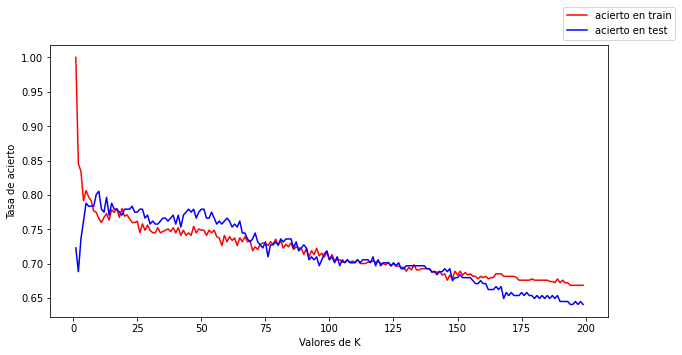

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('Valores de K')
plt.ylabel('Tasa de acierto')
plt.plot(k_vals, train_score, color = 'r', label = "acierto en train")
plt.plot(k_vals, test_score, color = 'b', label = 'acierto en test')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.show()

Fijando la semilla a 1, siempre obtenemos la misma partición train/test, por lo que el resultado siempre es igual (si comentas la semilla más arriba, verás que en cada ejecución la gráfica cambia). Tomando esta gráfica como referencia, parace que el acierto más alto en test lo conseguimos con $k=10$.

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 10)

# Ajustar el modelo
knn.fit(X_train,y_train)

# Obtener el acierto en test
knn.score(X_test,y_test)

0.8051948051948052

Podemos sacar las siguientes conclusiones de la gráfica:


*   Para valores bajos de $k$ el acierto del clasificador sobre los datos de entrenamiento es muy alto (OJO: aquí no estamos monitorizando el error, sino que el acierto, así que tenemos que dar la vuelta a lo visto en la teoría). Sin embargo, el acierto sobre los datos de test (o dev) es considerablemente menor. Si le damos la vuelta, estamos diciendo que el error en train es bajo y en dev claramente más alto. ¿A qué nos suena eso? Exactamente: para valores bajos de $k$ tenemos un clasificador con varianza alta y sesgo bajo. Estamos observando un fenómeno de **sobreajuste** (*overfitting*).
*   A medida que el valor de $k$ incrementa, el acierto en test va subiendo, a la vez que baja el acierto en train. Para valores muy altos de $k$ ($>100$), el acierto tanto en train como en test van hacia abajo. En ese régimen tenemos un clasificador con **sesgo alto** y **varianza alta** (lo peor de ambos mundos).
*   Hay un régimen interesante, alrededor de $k=10$. Allí vemos cómo el acierto en train y test van convergiendo a valores muy similares (train bajando y test subiendo). Se ve claramente la **compensación entre sesgo y varianza** (el famoso *bias-variance tradeoff*). A medida que $k$ incrementa, el clasificador va ganando en sesgo y perdiendo varianza. Para $k=10$ encontramos el equilibrio adecuado para este conjunto específico de datos.

## La perspectiva de la complejidad

Decíamos en la teoría, que cuanto más complejo sea un modelo, más capacidad tiene de aprender de los datos, y menos suposiciones hace sobre la naturaleza de la función objetivo $f$ que queremos aproximar. Eso hacía que el modelo tuviera mayor varianza y menor sesgo. En el caso del $k$-NN, aunque parezca poco intuitivo, el modelo es más complejo para valores pequeños de $k$. Las fronteras de decisión que puede aprender para $k=1$ pueden ser extremadamente complejas (no-linearidad alta). Por ello, la complejidad de un modelo $k$-NN es inversamente proporcional a $k$. 

Habiendo entendido esto, podemos analizar la gráfica del acierto para diferentes valores de $k$ desde la perspectiva de la complejidad del modelo. Para valores bajos de $k$, es decir, complejidad alta, el acierto en train es alto y en test considerablemente más bajo. Como esperábamos, la comlejidad hace que el modelo tenga una varianza alta y un sesgo bajo (*overfitting*). A medida que incrementamos el valor de $k$, estamos reduciendo la complejidad del modelo. Por ello, nuestro modelo va hacia un sesgo más alto (más suposiciones sobre la naturaleza de la función objetivo) y una varianza menor (se ve menos afectado por los datos de train).

